In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')

%matplotlib inline

In [242]:
# Leer datos de contaminacion de dic2017
contam1 = pd.read_csv('datos18.csv',encoding = 'iso-8859-1',delimiter = ';')
contam2 = pd.read_csv('datos17.csv',encoding = 'iso-8859-1',delimiter = ';')
contam = pd.concat([contam1, contam2])


In [243]:
# Usar sólo las mediciones de NO2 (magnitud = 8)
contam= contam[contam['MAGNITUD'] == 8]
# Crear columna de fecha y elminar columnas innecesarias

cols=['PROVINCIA','MUNICIPIO','MAGNITUD','PUNTO_MUESTREO']
contam.drop(cols,axis=1,inplace=True)

In [244]:
col_dias = ["{}_{}".format(h, tipo) for h in range(1, 32) for tipo in ("medida", "valido")]
contam.columns = ['estacion','ano','mes'] + col_dias 
contam.head()

,estacion,ano,mes,1_medida,1_valido,2_medida,2_valido,3_medida,3_valido,4_medida,...,27_medida,27_valido,28_medida,28_valido,29_medida,29_valido,30_medida,30_valido,31_medida,31_valido
30,4,2018,1,21.0,V,29.0,V,35.0,V,26.0,...,26.0,V,22.0,V,67.0,V,61.0,V,74.0,V
31,4,2018,2,58.0,V,47.0,V,41.0,V,31.0,...,55.0,V,52.0,V00000N00000N00000N,NaN,NaN,NaN,NaN,NaN,NaN
32,4,2018,3,35.0,V,53.0,V,27.0,V,25.0,...,40.0,V,41.0,V,14.0,V,9.0,V,16.0,V
33,4,2018,4,38.0,V,40.0,V,24.0,V,21.0,...,26.0,V,14.0,V,13.0,V,24.0,V00000N,NaN,NaN
34,4,2018,5,25.0,V,29.0,V,42.0,V,41.0,...,26.0,V,32.0,V,47.0,V,35.0,V,31.0,V


In [245]:
contam = contam.melt(id_vars=['estacion','ano','mes'])
contam.head()

,estacion,ano,mes,variable,value
0,4,2018,1,1_medida,21
1,4,2018,2,1_medida,58
2,4,2018,3,1_medida,35
3,4,2018,4,1_medida,38
4,4,2018,5,1_medida,25


In [246]:
# Separamos la columna 'variable' en dos: 'variable' y 'dia'
contam[["dia", "variable"]] = contam.variable.str.split("_", expand=True)
contam.head()

,estacion,ano,mes,variable,value,dia
0,4,2018,1,medida,21,1
1,4,2018,2,medida,58,1
2,4,2018,3,medida,35,1
3,4,2018,4,medida,38,1
4,4,2018,5,medida,25,1


In [247]:
contam = pd.pivot_table(contam, 
                        index=["estacion", "ano",  "mes", "dia"], 
                        columns="variable", values="value", aggfunc='first').reset_index()
contam['medida'] = contam['medida'].astype(int)
contam.head()

variable,estacion,ano,mes,dia,medida,valido
0,4,2017,1,1,50,V
1,4,2017,1,10,81,V
2,4,2017,1,11,70,V
3,4,2017,1,12,49,V
4,4,2017,1,13,46,V


In [248]:
# Seleccionamos sólo los datos que son válidos (valido = V)
contam = contam[contam['valido'].str.startswith('V')]

In [249]:
#convertimos dia mes y año en fecha
contam["dia"] = pd.to_numeric(contam["dia"])
contam['fecha'] = contam.apply(lambda x: datetime.date(x['ano'], x['mes'], x['dia']), axis=1)

contam.head()

variable,estacion,ano,mes,dia,medida,valido,fecha
0,4,2017,1,1,50,V,2017-01-01
1,4,2017,1,10,81,V,2017-01-10
2,4,2017,1,11,70,V,2017-01-11
3,4,2017,1,12,49,V,2017-01-12
4,4,2017,1,13,46,V,2017-01-13


In [250]:
contam["date"] = pd.to_datetime(contam.fecha) 
contam = contam[["estacion", "date", "medida"]]

In [251]:
estaciones = pd.read_csv("estaciones.csv",encoding = 'iso-8859-1',delimiter = ';')[["estacion", "zona"]].set_index("estacion")
contam = pd.merge(contam, estaciones, how="inner", left_on="estacion", right_index=True)

contam.head()

,estacion,date,medida,zona
0,4,2017-01-01,50,1
1,4,2017-01-10,81,1
2,4,2017-01-11,70,1
3,4,2017-01-12,49,1
4,4,2017-01-13,46,1


In [252]:
serie = contam.sort_values(['estacion', "date"], ascending=True).reset_index(drop= True)
serie.head()

,estacion,date,medida,zona
0,4,2017-01-01,50,1
1,4,2017-01-02,62,1
2,4,2017-01-03,71,1
3,4,2017-01-04,64,1
4,4,2017-01-05,59,1


In [253]:
media_zona = serie.groupby(['zona', 'date'])['medida'].mean().reset_index()
media_zona.head()

,zona,date,medida
0,1,2017-01-01,50.4
1,1,2017-01-02,55.0
2,1,2017-01-03,68.1
3,1,2017-01-04,72.6
4,1,2017-01-05,68.5


In [254]:
media = serie.groupby(['date'])['medida'].mean().reset_index()
media.head()

,date,medida
0,2017-01-01,48.000000
1,2017-01-02,53.375000
2,2017-01-03,67.208333
3,2017-01-04,68.666667
4,2017-01-05,65.750000


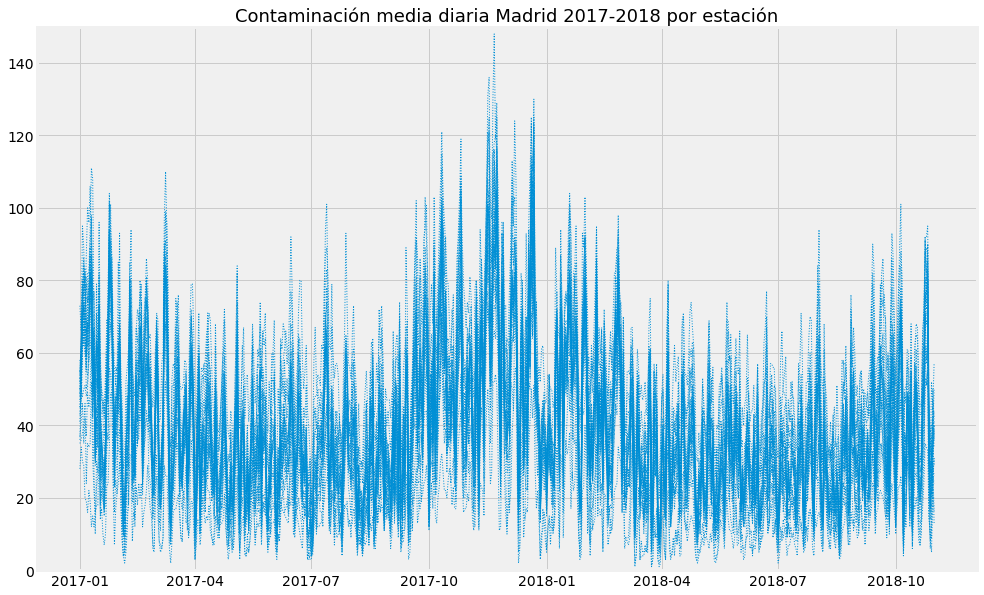

In [255]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 10),
         'axes.labelsize': 14,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
plt.rcParams.update(params)

estacion = serie['estacion'].unique()

for e in estacion:
    serie_e = serie[serie['estacion'] == e]
    x= serie_e['date']
    plt.plot(x, serie_e['medida'],lw=1, ls=':', alpha=1, color=sns.color_palette()[0])

plt.axis(ymin= 0 , ymax=150)
plt.title('Contaminación media diaria Madrid 2017-2018 por estación',fontsize= 18)
plt.savefig('images/historico_por_estacion.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

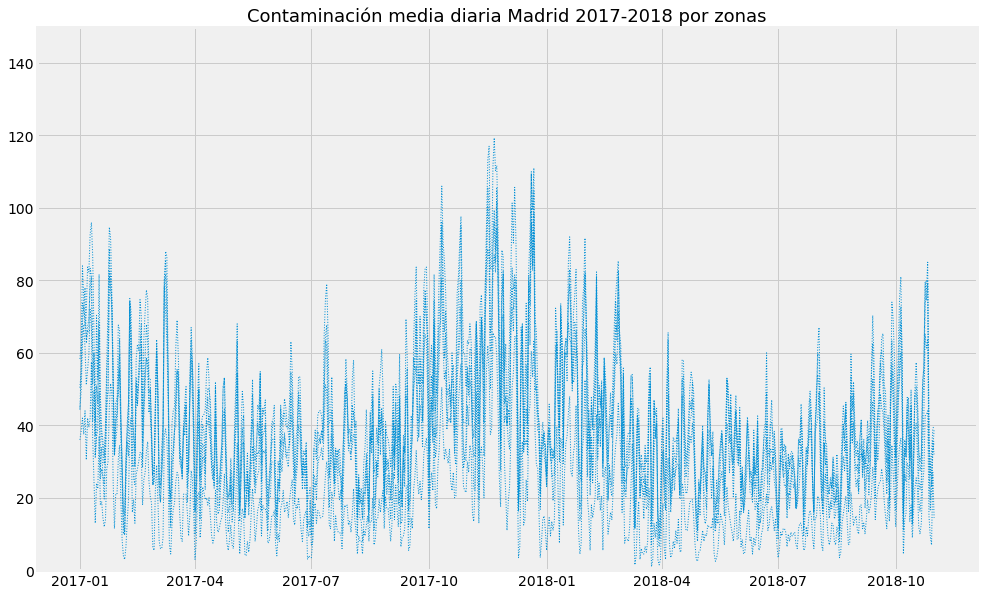

In [264]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 10),
         'axes.labelsize': 14,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
plt.rcParams.update(params)

zona = media_zona['zona'].unique()

for z in zona:
    serie_z = media_zona[media_zona['zona'] == z]
    x= serie_z['date']
    plt.plot(x, serie_z['medida'],lw=1, ls=':', alpha=1, color=sns.color_palette()[0])


plt.axis(ymin= 0 , ymax=150)
plt.title('Contaminación media diaria Madrid 2017-2018 por zonas',fontsize= 18)
plt.savefig('images/historico_por_zona.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

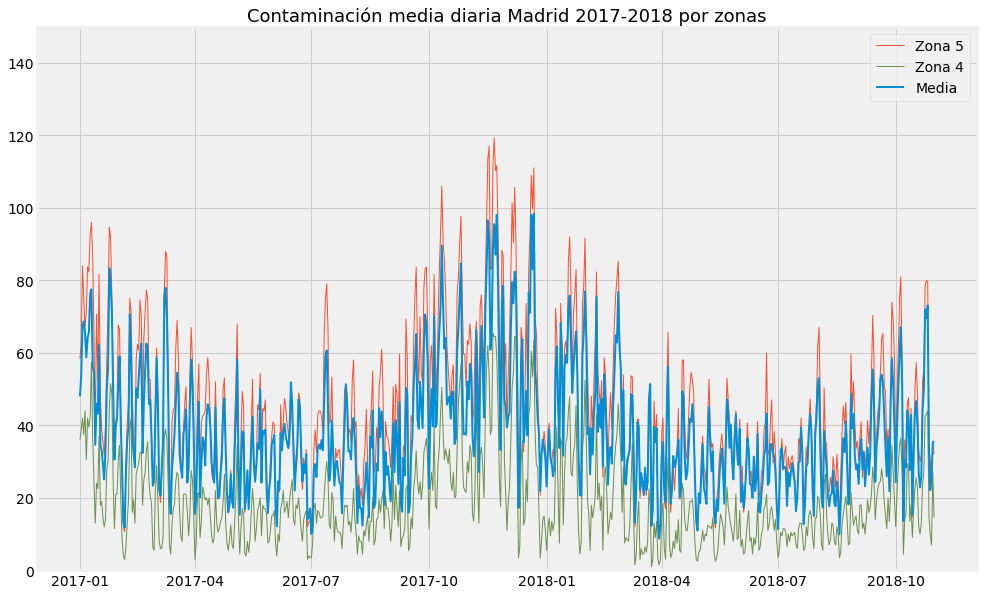

In [271]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 10),
         'axes.labelsize': 14,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
plt.rcParams.update(params)

#zona de máxima contaminación
serie_z = media_zona[media_zona['zona'] == 5]
x= serie_z['date']
plt.plot(x, serie_z['medida'],lw=1, ls='-', alpha=1, color=sns.color_palette()[1],label='Zona 5')

#zona de mínima contaminación
serie_z = media_zona[media_zona['zona'] == 4]
x= serie_z['date']
plt.plot(x, serie_z['medida'],lw=1, ls='-', alpha=1, color=sns.color_palette()[3],label='Zona 4')

#contaminación media de todas las estaciones
x= media['date']
plt.plot(x, media['medida'],lw=2, ls='-', alpha=1, color=sns.color_palette()[0], label='Media')

plt.legend()
plt.axis(ymin= 0 , ymax=150)
plt.title('Contaminación media diaria Madrid 2017-2018 por zonas',fontsize= 18)
plt.savefig('images/historico_por_zona.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()